# Memorization vs Generalization

Neuronale Netze gehören mittlerweile zum Standard-Repertoire des Maschienllen Lernens. Wir erwarten von ihnen, dass sie "einfach lernen". Doch was genau ist mit diesem Begiff eigentlich gemeint? 

## Lernen

Der Begriff _lernen_ lässt in diesem Zusammenhang zwei Interpretationen zu.
- "Learning by memorization": 
- _Generalisierung_: Aus den Trainingsdaten werden Features extrahiert, mit deren Hilfe unbekannte Daten entsprechend klassifiziert werden.

[Quelle?] 

In der Regel erwartet man bei dem Begriff _lernen_ zweiteres. Das Modell soll mit den Trainingsdaten lernen, zusammenhänge und Regeln zu erkennen und auf neue, ungesehene Daten anwenden können. 

In diesem Notebook werden wir uns jedoch mal mit dem ersteren beschäftigen – der Memorization. Auch hierbei leisten DNN durchaus erstaunliches und ein Verständnis dieser Thematik hilft dabei Netze zu entwickeln die besser generalisieren können. 

## Kapazität 

Jedes mathmatische Modell bestetht aus einer Anzahl bestimmten Anzahl an Parametern. Diese beschränken die Möglichkeit eines Modells, sich einer beliebigen Funktion anzunähern. 

Die Kapazität eines Neuronalen Netzwerkes bestimmt sich durch die Anzahl und Größe der verstecken Schichten. Als Richtwert, lässt sich die Anzahl der Parameter nutzen. 
Eine exakte Angabe der Kapazität ist jedoch nur schwer möglich. \cite{Deep Learning}



In [2]:
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD
import random, os, json

FORCE_BUILD_MODELS = False

Using TensorFlow backend.


Wir verwenden zu demonstrationszwecken das CIFAR10 Dataset, welches aus 50000 niedrig aufgelösten Bildern besteht, welche 10 verschiedenen Klassen zugeordnet sind. 

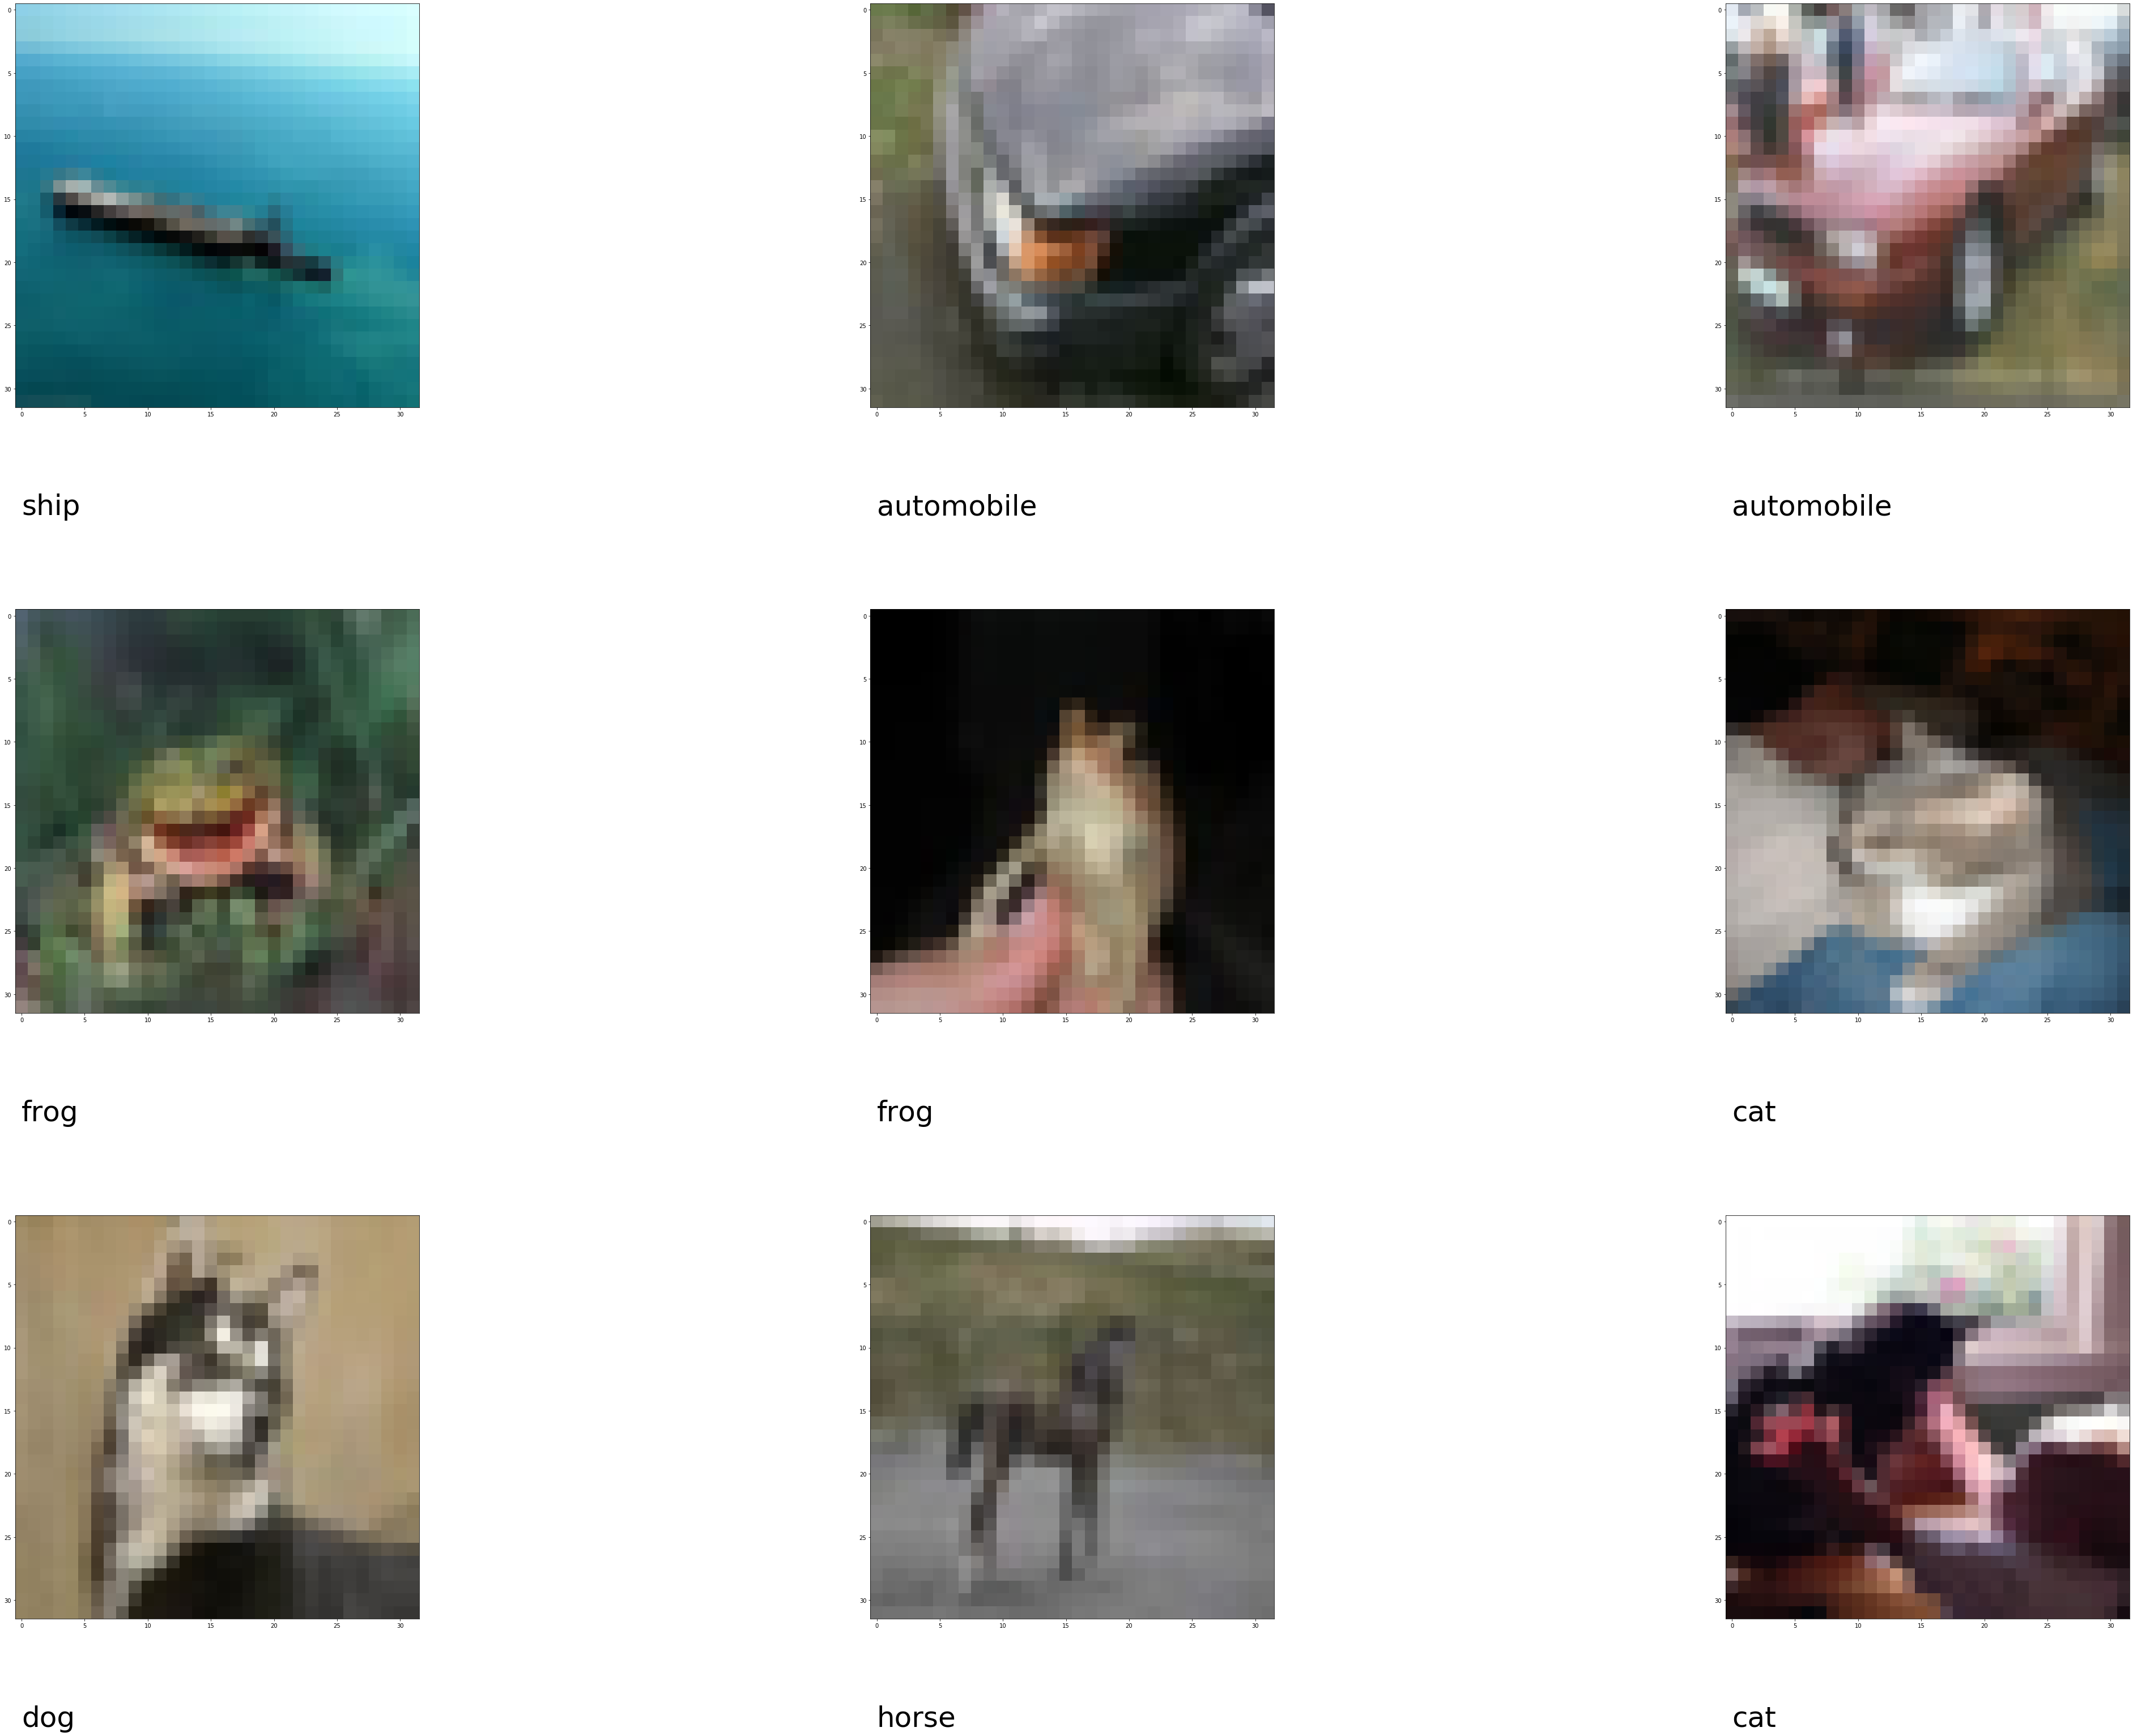

In [3]:
(trainX, trainY), (testX, testY) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(9):
    nr = random.randint(1, len(trainX))
    pyplot.subplot(330 + 1 + i, ymargin=20)
    pyplot.imshow(trainX[nr])
    pyplot.text(0, 40, class_names[trainY[nr][0]], fontsize=50)

#pyplot.tight_layout()
pyplot.subplots_adjust(left=0.1, right=10.0, top=10.0, bottom=0.1, hspace=0.5)
pyplot.show()



In [4]:

#trainX = trainX[:10000,:,:,:]
#testX = testX[:5000,:,:,:]

#trainY = trainY[:10000]
#testY = testY[:5000]

trainY_shuffle = list(trainY)
random.shuffle(trainY_shuffle)


In [5]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)
trainY_shuffle = to_categorical(trainY_shuffle)

trainX = trainX.astype('float32')
testX = testX.astype('float32')

trainX = trainX / 255.0
testX = testX / 255.0

In [6]:
def create_model(conv1, conv2, conv3, dropout, dense):
    model = Sequential()
    model.add(Conv2D(conv1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(conv1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    if dropout:
        model.add(Dropout(dropout))
    model.add(MaxPooling2D((2, 2)))
    if conv2 != 0:
        model.add(Conv2D(conv2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        if dropout:
            model.add(Dropout(dropout))
        model.add(MaxPooling2D((2, 2)))
    if conv3 != 0:
        model.add(Conv2D(conv3, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv3, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        if dropout:
            model.add(Dropout(dropout))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(dense, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_summary(history):
    # Plot the loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history['loss'], color='blue', label='train')
    pyplot.plot(history['val_loss'], color='red', label='test')
    pyplot.legend(loc='lower right')
    # Plot the accuracy
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history['acc'], color='blue', label='train')
    pyplot.plot(history['val_acc'], color='red', label='test')
    pyplot.legend(loc='lower right')

    
def create_or_load_model(name, model_params, train_func):
    model_path = 'models/{}.model'.format(name)
    history_path = 'models/{}_history.json'.format(name)
    if os.path.isfile(model_path) and not FORCE_BUILD_MODELS:
        
        model = load_model(model_path)
        with open(history_path) as file:
            history = json.load(file)
    else:
        model = create_model(*model_params)
        history = train_func(model)
        model.save(model_path)
        with open(history_path, 'w') as file:
            json.dump(history.history, file)
            history = history.history
    return (model, history)

## Tests

Wir teste ein sehr kleines Netz, welches nicht in der Lage ist, die Features ausreichend zu abstrahieren, aber nach vielen Episoden irgendwann trotzdem genug Kapazität hat, um die Daten zu erinnern. 

In [7]:
model_small, history_small = create_or_load_model('small', (3, 0, 0, False, 128), lambda model: model.fit(trainX, trainY, epochs=200, batch_size=64, validation_data=(testX, testY)))



W0813 16:11:54.378865 140226656274048 deprecation_wrapper.py:119] From /home/robin/WVIN/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 16:11:54.399280 140226656274048 deprecation_wrapper.py:119] From /home/robin/WVIN/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 16:11:54.429542 140226656274048 deprecation_wrapper.py:119] From /home/robin/WVIN/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0813 16:11:54.471372 140226656274048 deprecation_wrapper.py:119] From /home/robin/WVIN/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0

Parameter: 99,890
Final Accuracy: 0.99978; Final Validation Accuracy: 0.4961


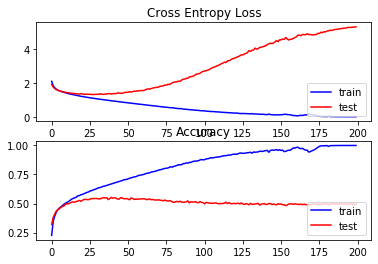

In [8]:
print("Parameter: {:,}".format(model_small.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_small['acc'][-1], history_small['val_acc'][-1]))
plot_summary(history_small)

Es zeigt sich, dass ein kleines Netz mit 33 576 Parametern nicht in der Lage ist, die Daten ausreichend zu generalisieren, aber trotzdem nach genug Trainingsepisoden die 50 000 Trainingsdaten erinnern kann. 

Als nächstes ein Netz einer "normalen" Größe, welches in der Lage ist, die CIFAR10 Challange in einem ausreichenden Maß zu meistern.

In [9]:
model_normal, history_normal = create_or_load_model('normal', (32, 64, 128, False, 512), lambda model: model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY)))

Parameter: 1,341,226
Final Accuracy: 1.0; Final Validation Accuracy: 0.7166


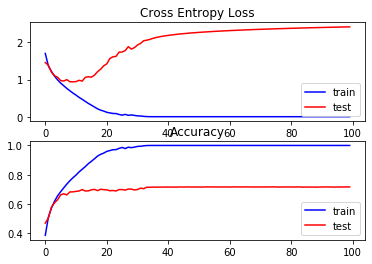

In [10]:
print("Parameter: {:,}".format(model_normal.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_normal['acc'][-1], history_normal['val_acc'][-1]))
plot_summary(history_normal)

Dieses Netz ist das gleiche wie oben, nur dass dieses mal die randomisierten Labels als Y-Daten genutzt werden.

In [11]:
model_random, history_random = create_or_load_model('random', (32, 64, 128, False, 512), lambda model: model.fit(trainX, trainY_shuffle, epochs=100, batch_size=64,  validation_data=(testX, testY)))


Parameter: 1,341,226
Final Accuracy: 0.987; Final Validation Accuracy: 0.0987


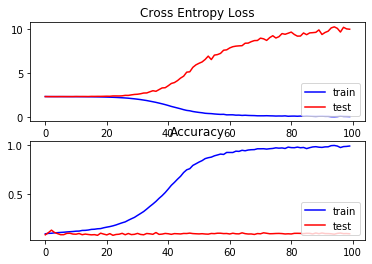

In [12]:
print("Parameter: {:,}".format(model_random.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_random['acc'][-1], history_random['val_acc'][-1]))
plot_summary(history_random)

## Vergleiche

Im folgenden Diagramm wird die Accuracy der Validationsets über 100 Episoden dargestellt.

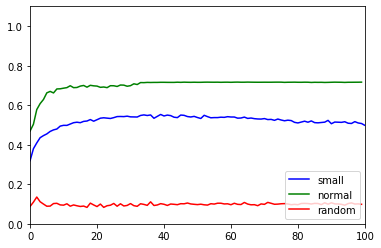

In [13]:
pyplot.plot(history_small['val_acc'], color='blue', label='small')
pyplot.plot(history_normal['val_acc'], color='green', label='normal')
pyplot.plot(history_random['val_acc'], color='red', label='random')
pyplot.axis([0, 100, 0, 1.1])
pyplot.legend(loc='lower right')
pyplot.show()

Wenig überraschend ist die Performance des randomisierten Modells bei knapp 10%, was bei 10 Klassen genau der zu erwartenten Wahrscheinlichkeit einer rein zufälligen Klassenzuordnung entspricht. Das Modell hat aus den Trainingsdaten also keine Regeln zur Generalisierung ableiten können.

Das kleine Modell erreicht mit seinen 99k Parametern nur eine generalisierungs Performance von knapp 50%. Auch nach sehr vielen Episoden steigt diese Leistung nicht weiter an. 

Das folgende Diagramm vergleicht die Accuracy der Trainingsdaten der 3 Versuche miteinander.

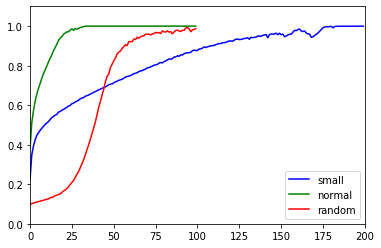

In [14]:
pyplot.plot(history_small['acc'], color='blue', label='small')
pyplot.plot(history_normal['acc'], color='green', label='normal')
pyplot.plot(history_random['acc'], color='red', label='random')
pyplot.axis([0, 200, 0, 1.1])
pyplot.legend(loc='lower right')
pyplot.show()

Hier ergibt sich ein interessanteres Bild. Alle Modelle sind in der Lage, die Klassifikation der Daten nahezu vollständig zu erinnern. Auch das Modell, welches die Daten mit randomisierten Klassen zum Training bekommen hat, ist nach einer langsamen Anfangsphase relativ schnell in der Lage die Daten zu erinnern. Der Großteil des "auswendig lernens" passiert innerhalb von nur 25 Episoden, eine ähnlich lange Zeit benötigt auch das "normale" Modell, nur dass hier die Erinnerung schon nach 25 Episoden fast abgeschlossen ist. 


[Erinnerung zusammen mit lernen, deshalb schneller]

## Overfitting

In direkter Verbindung zu der Fähigkeit von DNN "auswendig" zu lernen steht das sogenannte Overfitting. Overfitting – Überanpassung – entsteht immer dann, wenn ein Modell zu sehr auf spezielle Trainingsdaten traniert wird und damit die generalisierungsleistung abnimmt. {@Explore overfitting and underfitting}
Nach herkömlicher Theorie entsteht eine Überanpassung, wenn ein Modell deutlich mehr Parameter hat als Trainingsdaten. Im Rahmen von DNN verhält sich dies etwas anders und die Gründe hierfür sind noch nicht ausreichend erforscht. {@A Closer Look at Memorization in Deep Networks}




- Statt generalisieren
- nicht erwünscht, da generalisierung abnimmt
- zu viele trainingsepisoden
- zu große kapazität

## Regularization

Eine weitere Methode um zu verhindern, dass DNNs die Daten auswendig lernen sind explizite Regularisierungstechniken. 

Hier kommen insbesondere 2 Verfahren in Betracht:
- Dropout: Beim Dropout wird ein Teil der Neuronen einer Schicht bei jedem Schritt des Trainings deaktiviert. 
- Batch Normalization

Zur Verdeutlichung der Funktionsweise von Regularisierung betrachten wir an dieser Stelle Dropout. Die Vorgehensweise ist leicht auf andere Regularisierungsverfahren übertragbar. 

Wir trainieren ein Modell mit Dropout-Schichten mit den _echten_ Labels und eins mit den randomisierten. 





### Regularization Normal

In [15]:
model_reg_normal, history_reg_normal = create_or_load_model('reg_normal', (32, 64, 128, 0.2, 512), lambda model: model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY)))

W0813 16:11:57.097368 140226656274048 deprecation.py:506] From /home/robin/WVIN/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Parameter: 1,341,226
Final Accuracy: 0.99272; Final Validation Accuracy: 0.7873


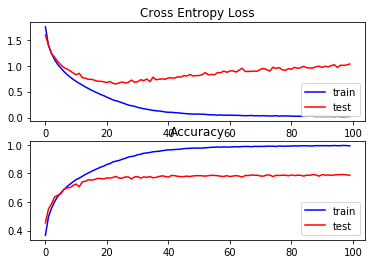

In [16]:
print("Parameter: {:,}".format(model_reg_normal.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_reg_normal['acc'][-1], history_reg_normal['val_acc'][-1]))
plot_summary(history_reg_normal)

### Regularization random

In [17]:
model_reg_random, history_reg_random = create_or_load_model('reg_random', (32, 64, 128, 0.2, 512), lambda model: model.fit(trainX, trainY_shuffle, epochs=100, batch_size=64, validation_data=(testX, testY)))

Parameter: 1,341,226
Final Accuracy: 0.7411; Final Validation Accuracy: 0.0998


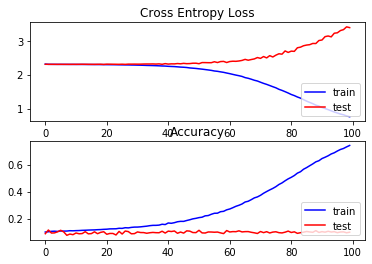

In [18]:
print("Parameter: {:,}".format(model_reg_random.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_reg_random['acc'][-1], history_reg_random['val_acc'][-1]))
plot_summary(history_reg_random)

### Vergleich mit und ohne Dropout

#### Normale Trainingsdaten

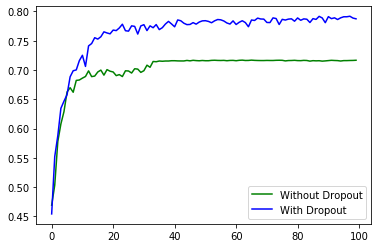

In [21]:
pyplot.plot(history_normal['val_acc'], color='green', label='Without Dropout')
pyplot.plot(history_reg_normal['val_acc'], color='blue', label='With Dropout')
pyplot.legend(loc='lower right')
pyplot.show()

#### Randomisierte Trainingsdaten

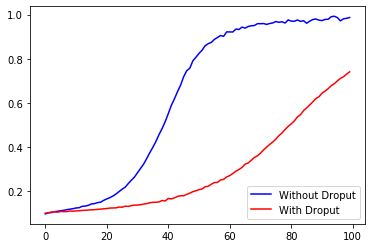

In [20]:
pyplot.plot(history_random['acc'], color='blue', label='Without Droput')
pyplot.plot(history_reg_random['acc'], color='red', label='With Droput')
pyplot.legend(loc='lower right')
pyplot.show()

Es wird schnell deutlich, dass das Modell mit Regularisierungsschichten die Daten deutlich langsamer lernt, als das Modell ohne Dropout und zusätzlich ist die Accuracy nach 100 Episoden nur bei knapp 75%. Im Kontext der Verhinderung von Overfitting ist dies das gewünschte Verhalten und ein Anhaltspunkt dafür, dass Dropout ein effektives Mittel gegen Overfitting ist.